In [33]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZGate, XGate
from math import sqrt, pi
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [34]:
def inversaoSobreMedia(n_bits, controlado=False):
  q_reg = QuantumRegister(n_bits)

  if controlado:
    c_reg = QuantumRegister(1)

    qc = QuantumCircuit(c_reg, q_reg, name="C-inv-media")

    qc.ch(c_reg[0], q_reg)
    qc.cx(c_reg[0], q_reg)

    # qc.cx(c_reg[0], n_bits-1)

    qc.append(ZGate().control(num_ctrl_qubits=n_bits, ctrl_state="1"*(n_bits-1)+"1"), [c_reg] + q_reg[:])

    # qc.cx(c_reg[0], n_bits-1)
    qc.cx(c_reg[0], q_reg)

    qc.ch(c_reg[0], q_reg)
  else:
    qc = QuantumCircuit(q_reg, name="inv-media")

    qc.h(q_reg)

    # qc.x(n_bits-1)
    qc.x(q_reg)

    qc.append(ZGate().control(num_ctrl_qubits=n_bits-1, ctrl_state="1"*(n_bits-1)), q_reg)

    # qc.x(n_bits-1)
    qc.x(q_reg)

    qc.h(q_reg)

  return qc

# inversaoSobreMedia(5).draw("mpl")


In [35]:
def UF_SAT(n_bits, SAT, controlado=False):
  q_reg = QuantumRegister(n_bits, "q")

  aux_bits = len(SAT)

  anc_reg = QuantumRegister(aux_bits + 1, "anc")

  if controlado:
    c_reg = QuantumRegister(1, "c")

    qc = QuantumCircuit(c_reg, q_reg, anc_reg, name="C-UF")

    qc.x(anc_reg[:-1])

    for j in range(len(SAT)):
      ctrlstate = ""
      listaQuBits = []
      for i in SAT[j]:
        if i>0:
          ctrlstate += "0"
        else:
          ctrlstate += "1"
        listaQuBits.append(q_reg[abs(i)-1])

      qc.append(XGate().control(num_ctrl_qubits=len(SAT[j])+1, ctrl_state=ctrlstate[::-1]+"1"), c_reg[:] + listaQuBits[:] + anc_reg[j:j+1])

    qc.append(XGate().control(num_ctrl_qubits=aux_bits+1, ctrl_state="1"*(aux_bits)+"1"), c_reg[:] + anc_reg[:])

  else:

    qc = QuantumCircuit(q_reg, anc_reg, name="UF")

    qc.x(anc_reg[:-1])

    for j in range(len(SAT)):
      ctrlstate = ""
      listaQuBits = []
      for i in SAT[j]:
        if i>0:
          ctrlstate += "0"
        else:
          ctrlstate += "1"
        listaQuBits.append(q_reg[abs(i)-1])

      qc.append(XGate().control(num_ctrl_qubits=len(SAT[j]), ctrl_state=ctrlstate[::-1]), listaQuBits[:] + anc_reg[j:j+1])

    qc.append(XGate().control(num_ctrl_qubits=aux_bits, ctrl_state="1"*(aux_bits)), anc_reg)

  return qc

In [36]:
def UG_SAT(n_variaveis_SAT, SAT, controlado=False):
  num_expressoes_SAT = len(SAT)

  q_reg = QuantumRegister(n_variaveis_SAT+num_expressoes_SAT+1, "q_reg")

  if controlado:
    c_reg = QuantumRegister(1, "c_reg")

    num_expressoes_SAT = len(SAT)

    qc = QuantumCircuit(c_reg, q_reg, name="C-UG")

    qc.append(UF_SAT(n_variaveis_SAT, SAT, controlado=True), c_reg[:] + q_reg[:])

    #qc.x(n_variaveis_SAT+num_expressoes_SAT)
    qc.cz(c_reg[0], n_variaveis_SAT+num_expressoes_SAT+1)
    #qc.x(n_variaveis_SAT+num_expressoes_SAT)

    qc.append(UF_SAT(n_variaveis_SAT, SAT, controlado=True).inverse(), c_reg[:] + q_reg[:])

  else:

    qc = QuantumCircuit(q_reg, name="UG")

    qc.append(UF_SAT(n_variaveis_SAT, SAT), q_reg)

    #qc.x(n_variaveis_SAT+num_expressoes_SAT)
    qc.z(n_variaveis_SAT+num_expressoes_SAT)
    #qc.x(n_variaveis_SAT+num_expressoes_SAT)

    qc.append(UF_SAT(n_variaveis_SAT, SAT).inverse(), q_reg)

  return qc

In [37]:
def Grover(n_variaveis_SAT, SAT, controlado=False):
  num_expressoes_SAT = len(SAT)

  q_reg = QuantumRegister(n_variaveis_SAT, "q_reg")

  anc_reg = QuantumRegister(num_expressoes_SAT+1, "anc")

  if controlado:
    c_reg = QuantumRegister(1, "c_reg")

    qc = QuantumCircuit(c_reg, q_reg, anc_reg, name="C-Grover")

    qc.append(UG_SAT(n_variaveis_SAT, SAT, controlado=True), c_reg[:] + q_reg[:] + anc_reg[:])
    qc.append(inversaoSobreMedia(n_variaveis_SAT, controlado=True), c_reg[:] + q_reg[:])

  else:
    qc = QuantumCircuit(q_reg, anc_reg, name="Grover")

    qc.append(UG_SAT(n_variaveis_SAT, SAT), q_reg[:] + anc_reg[:])
    qc.append(inversaoSobreMedia(n_variaveis_SAT), q_reg)

  return qc

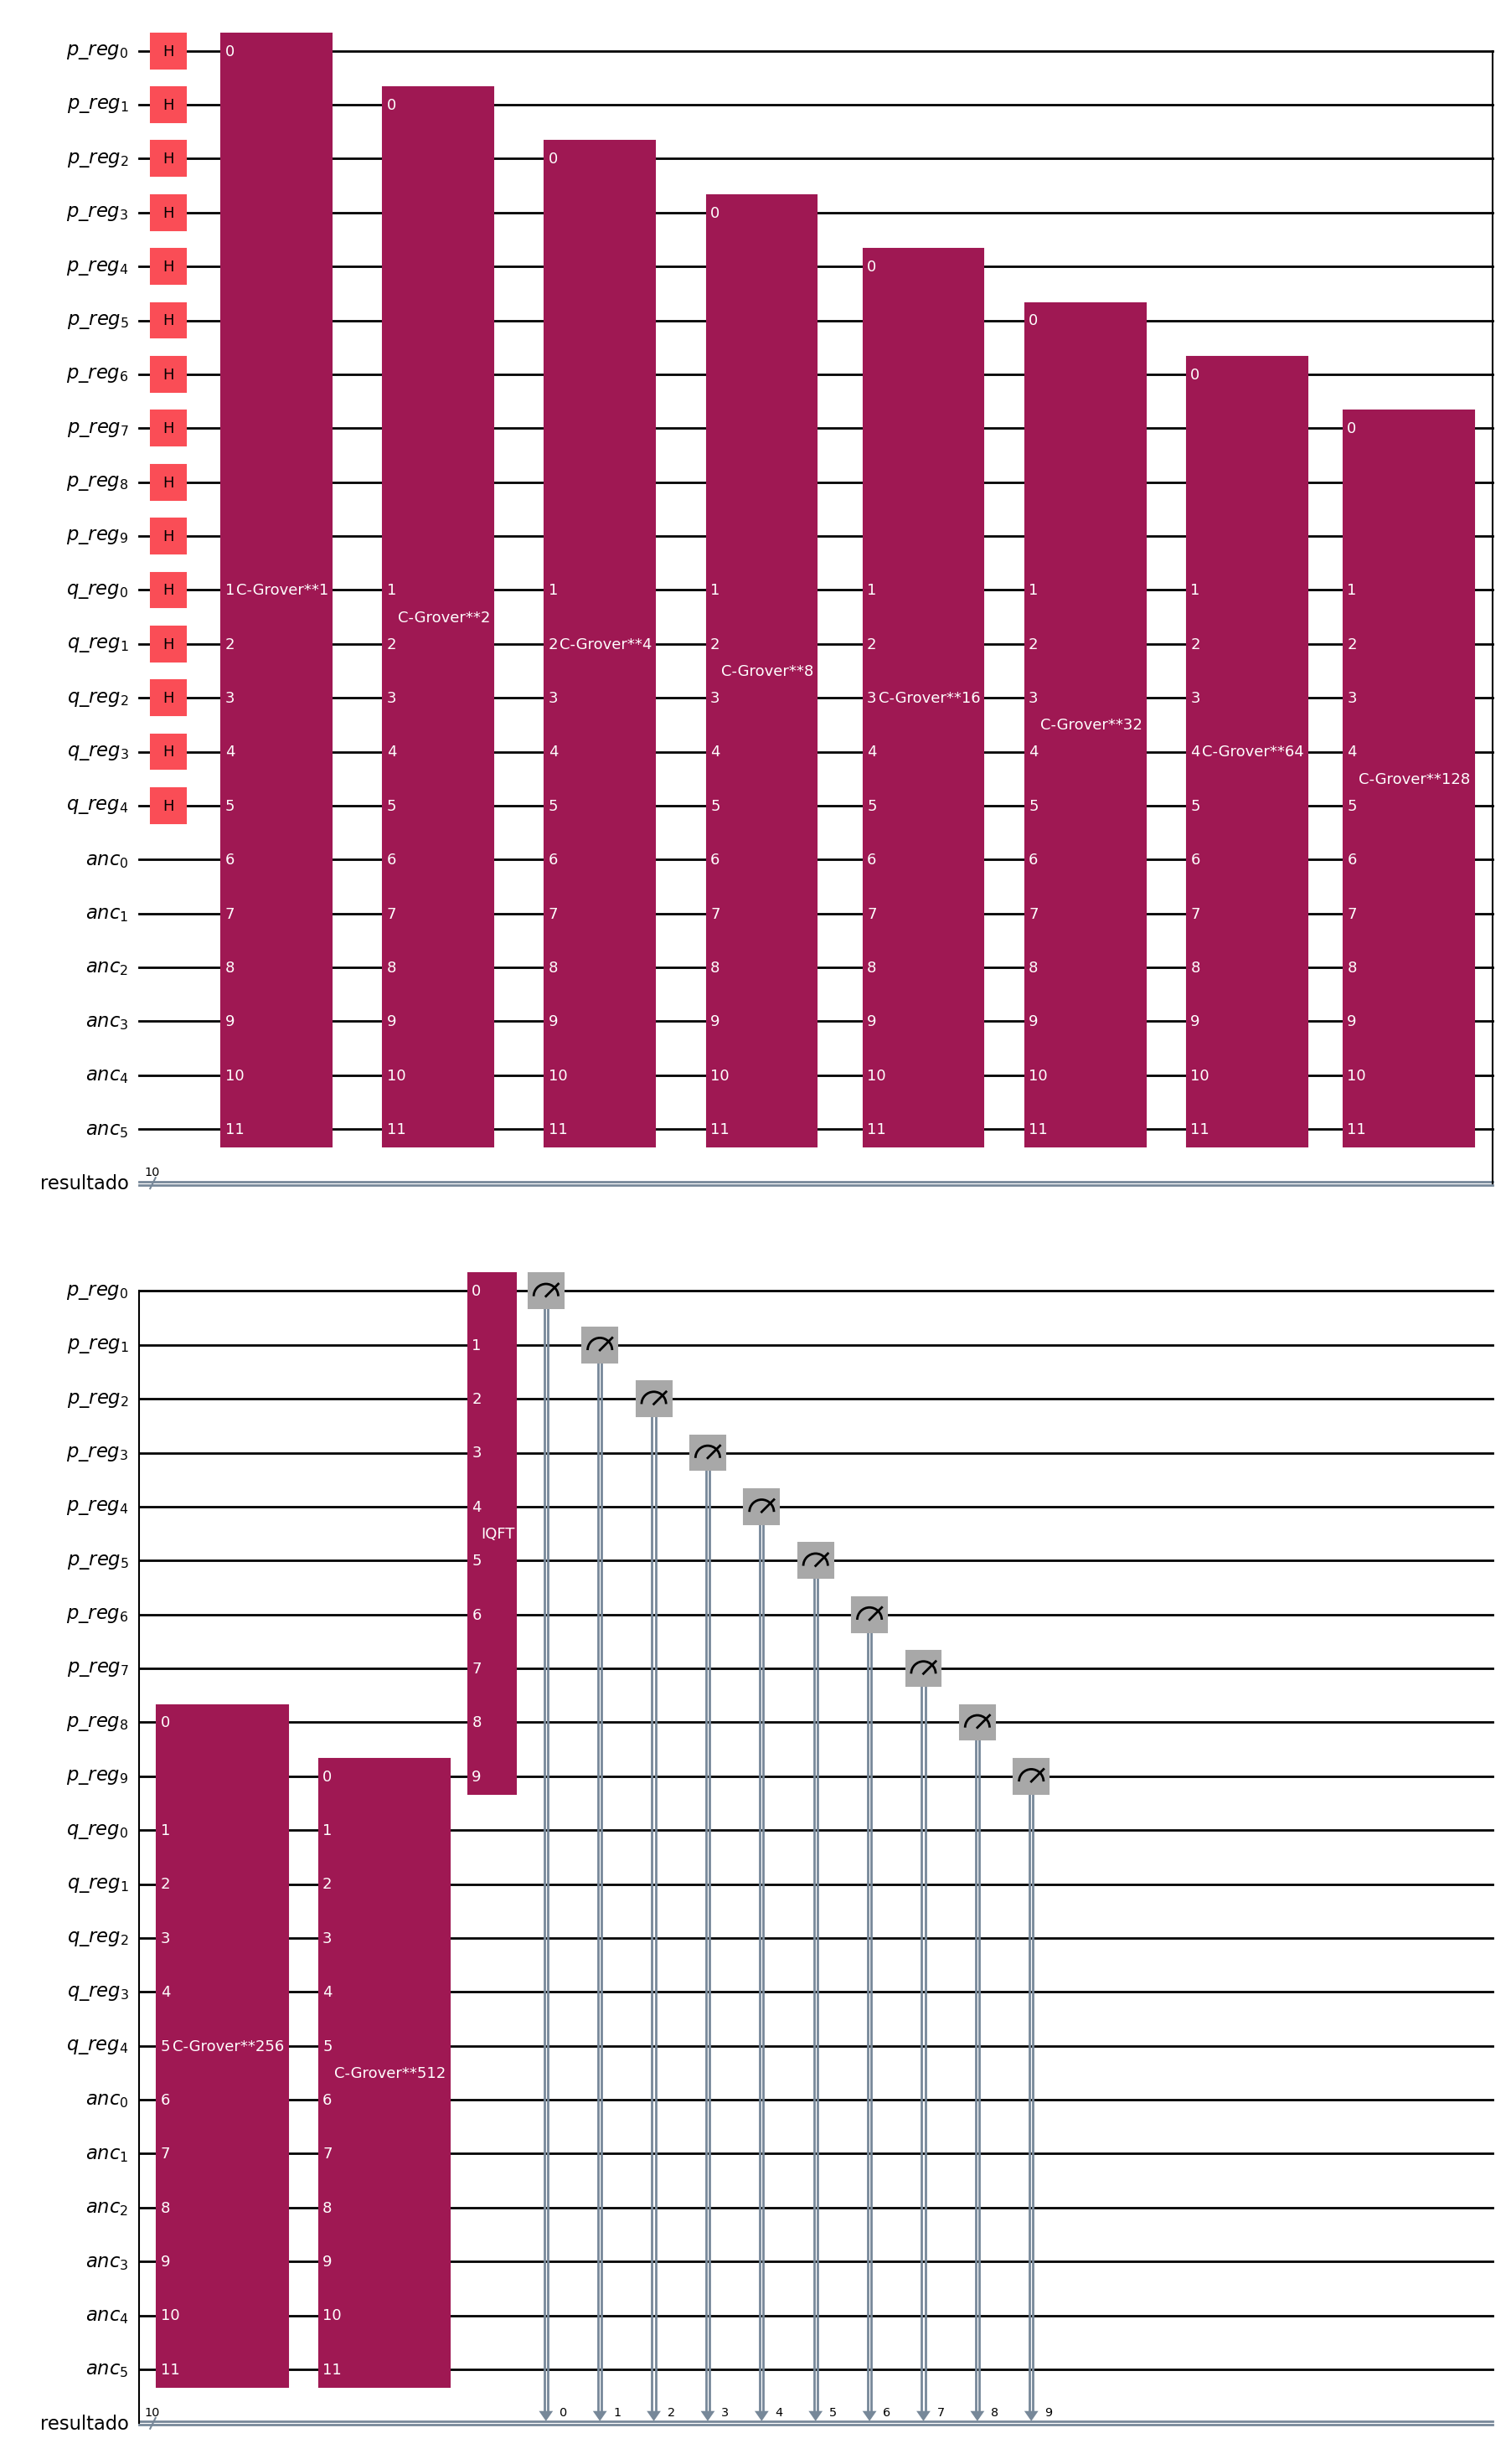

In [38]:
from qiskit.circuit.library import QFT
from qiskit.circuit import AnnotatedOperation, PowerModifier

n_variaveis_SAT = 5
# num_expressoes_SAT = 7

SAT = [[1, 2, -5], [-1, -3, 4], [2, 3, -4], [-2, -3, 5], [1, -2, 3]]

num_expressoes_SAT = len(SAT)
# for i in range(num_expressoes_SAT):
#   SAT.append(list(map(int, input().split())))

p_bits = 2*n_variaveis_SAT

p_reg = QuantumRegister(p_bits, "p_reg")

q_reg = QuantumRegister(n_variaveis_SAT, "q_reg")

anc_reg = QuantumRegister(num_expressoes_SAT+1, "anc")

c_reg = ClassicalRegister(p_bits, "resultado")

qc = QuantumCircuit(p_reg, q_reg, anc_reg, c_reg)

qc.h(p_reg)

qc.h(q_reg)

for i in range(p_bits):
  qc.append(Grover(n_variaveis_SAT, SAT, controlado=True).power(2**i), p_reg[i:i+1] + q_reg[:] + anc_reg[:])
  

qc.append(QFT(p_bits, inverse=True), p_reg)

qc.measure(p_reg, c_reg)

qc.draw("mpl")

In [39]:
backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1)

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1<<15)

countsCountingAlgorithm = job.result()[0].data.resultado.get_int_counts()

print(countsCountingAlgorithm)

{747: 4772, 748: 8696, 276: 8644, 277: 4788, 755: 34, 744: 119, 279: 255, 749: 773, 752: 83, 746: 654, 278: 668, 743: 78, 273: 125, 732: 8, 738: 13, 281: 79, 751: 132, 271: 56, 274: 249, 275: 769, 750: 263, 742: 48, 270: 40, 205: 2, 286: 9, 739: 30, 291: 10, 768: 5, 769: 4, 888: 1, 759: 9, 257: 8, 708: 2, 758: 12, 280: 109, 696: 1, 753: 42, 259: 5, 284: 27, 745: 220, 741: 39, 282: 57, 272: 73, 731: 4, 313: 3, 757: 14, 740: 24, 766: 5, 756: 15, 266: 15, 288: 10, 348: 1, 287: 22, 784: 2, 269: 21, 252: 2, 310: 4, 262: 11, 268: 21, 255: 3, 761: 8, 324: 3, 290: 5, 807: 2, 344: 1, 832: 1, 251: 7, 263: 11, 256: 2, 737: 17, 240: 1, 289: 7, 785: 1, 735: 9, 786: 1, 733: 3, 727: 3, 248: 7, 734: 11, 762: 14, 760: 17, 267: 23, 771: 5, 765: 5, 156: 1, 754: 33, 767: 7, 261: 4, 720: 3, 265: 9, 377: 1, 356: 1, 223: 1, 764: 4, 283: 33, 707: 3, 285: 20, 713: 3, 869: 1, 110: 1, 297: 6, 718: 5, 200: 1, 243: 2, 229: 1, 736: 10, 988: 1, 684: 1, 321: 1, 906: 1, 300: 3, 302: 1, 225: 3, 253: 3, 264: 9, 232: 2, 

In [40]:
lcounts = []

for i in countsCountingAlgorithm:
    lcounts.append((i, countsCountingAlgorithm[i]))

lcounts.sort(reverse=True, key=lambda x: x[1])
print(lcounts)

[(748, 8696), (276, 8644), (277, 4788), (747, 4772), (749, 773), (275, 769), (278, 668), (746, 654), (750, 263), (279, 255), (274, 249), (745, 220), (751, 132), (273, 125), (744, 119), (280, 109), (752, 83), (281, 79), (743, 78), (272, 73), (282, 57), (271, 56), (742, 48), (753, 42), (270, 40), (741, 39), (755, 34), (754, 33), (283, 33), (739, 30), (284, 27), (740, 24), (267, 23), (287, 22), (269, 21), (268, 21), (285, 20), (737, 17), (760, 17), (756, 15), (266, 15), (757, 14), (762, 14), (738, 13), (758, 12), (262, 11), (263, 11), (734, 11), (291, 10), (288, 10), (736, 10), (286, 9), (759, 9), (735, 9), (265, 9), (264, 9), (763, 9), (732, 8), (257, 8), (761, 8), (292, 8), (251, 7), (289, 7), (248, 7), (767, 7), (260, 7), (297, 6), (725, 6), (768, 5), (259, 5), (766, 5), (290, 5), (771, 5), (765, 5), (718, 5), (250, 5), (769, 4), (731, 4), (310, 4), (261, 4), (764, 4), (296, 4), (770, 4), (726, 4), (313, 3), (255, 3), (324, 3), (733, 3), (727, 3), (720, 3), (707, 3), (713, 3), (300, 3)

In [41]:
Resultado = job.result()[0].data.resultado.get_int_counts()

for i in range(1<<(p_bits)):
  if i not in Resultado:
    Resultado[i] = 0

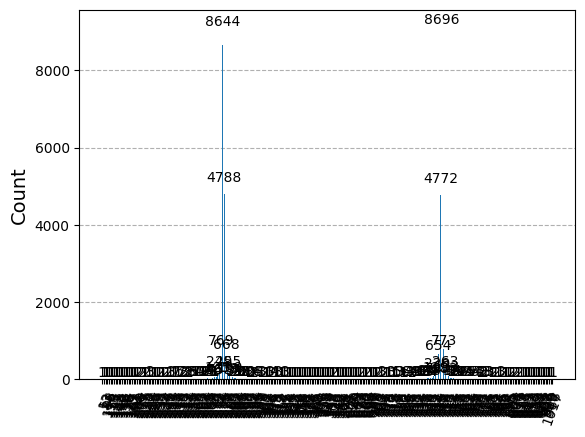

In [42]:
from qiskit.visualization import plot_histogram

plot_histogram(countsCountingAlgorithm)

In [43]:
from math import *

v1 = lcountsCountingAlgorithm[0][0]
v2 = lcountsCountingAlgorithm[1][0]

# a medição é 2^p_bits * teta /2pi
t = (2*pi*v1)/(2**p_bits) # isso calcula o teta baseado nessa medição
N = 2**n_variaveis_SAT
m = N*(sin(t/2))**2 # sen²(teta/2) = sqrt(M/N)

lm = [] 

print(t)
print(m)
print("Número de soluções: ", round(N-m))
print()
lm.append(round(N-m))

t = (2*pi*v2)/(2**p_bits)
N = 2**n_variaveis_SAT
m = N*(sin(t/2))**2

print(t)
print(m)
print("Número de de soluções: ", round(N-m))
lm.append(round(N-m))
print()

print(lm)

NameError: name 'lcountsCountingAlgorithm' is not defined

1


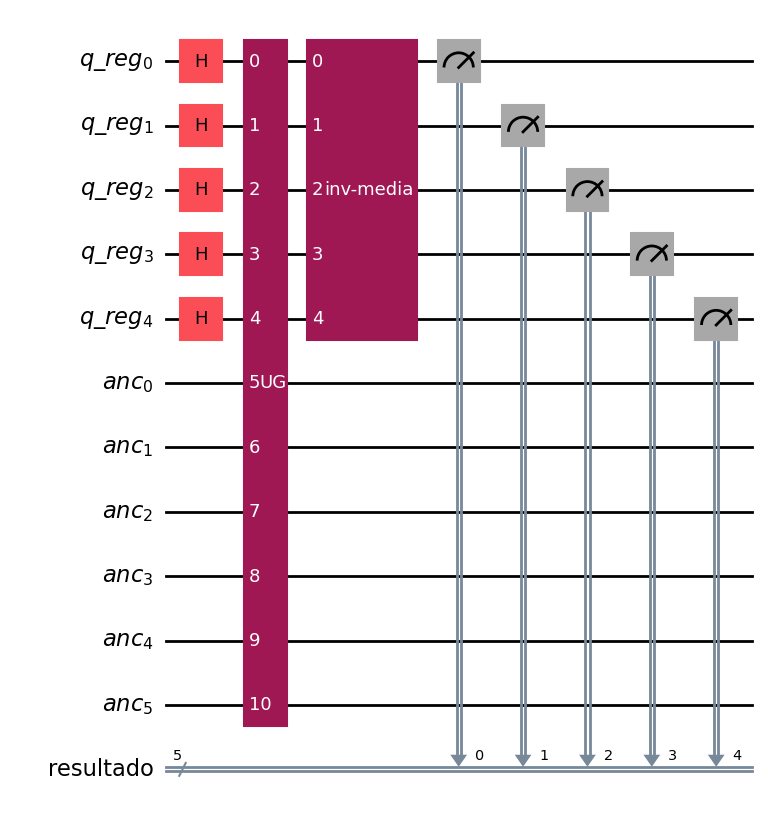

In [ ]:

q_reg = QuantumRegister(n_variaveis_SAT, "q_reg")

anc_reg = QuantumRegister(num_expressoes_SAT+1, "anc")

c_reg = ClassicalRegister(n_variaveis_SAT, "resultado")

qc = QuantumCircuit(q_reg, anc_reg, c_reg)

qc.h(q_reg)


if (lm[0] == lm[1]):
  valor = lm[0]
elif (lm[0] < 0):
  valor = lm[1]
else:
  valor = lm[0]

repeticoes = round((pi/4)*sqrt(2**n_variaveis_SAT/valor))

print(repeticoes)

for i in range(repeticoes):
  qc.append(UG_SAT(n_variaveis_SAT, SAT), q_reg[:] + anc_reg[:])
  qc.append(inversaoSobreMedia(n_variaveis_SAT), q_reg)

qc.measure(q_reg, c_reg)

qc.draw("mpl")


In [ ]:
backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1)

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1<<15)

countsGrover = job.result()[0].data.resultado.get_int_counts()

print(countsGrover)

{28: 572, 15: 567, 27: 1639, 17: 1663, 30: 1580, 19: 1613, 9: 582, 20: 601, 12: 1608, 31: 1578, 29: 1547, 0: 1593, 21: 573, 22: 1579, 16: 587, 1: 1626, 11: 1611, 14: 589, 5: 553, 2: 562, 18: 569, 4: 1618, 10: 556, 13: 1584, 3: 1620, 24: 579, 26: 585, 8: 547, 6: 583, 7: 564, 23: 597, 25: 543}


In [ ]:
lcountsGrover = []

for i in countsGrover:
    lcounts.append((i, countsGrover[i]))

lcountsGrover.sort(reverse=True, key=lambda x: x[1])
print(lcounts)

[(17, 1663), (27, 1639), (1, 1626), (3, 1620), (4, 1618), (19, 1613), (11, 1611), (12, 1608), (0, 1593), (13, 1584), (30, 1580), (22, 1579), (31, 1578), (29, 1547), (20, 601), (23, 597), (14, 589), (16, 587), (26, 585), (6, 583), (9, 582), (24, 579), (21, 573), (28, 572), (18, 569), (15, 567), (7, 564), (2, 562), (10, 556), (5, 553), (8, 547), (25, 543)]


In [ ]:
Resultado = job.result()[0].data.resultado.get_int_counts()

for i in range(1<<(n_variaveis_SAT)):
  if i not in Resultado:
    Resultado[i] = 0

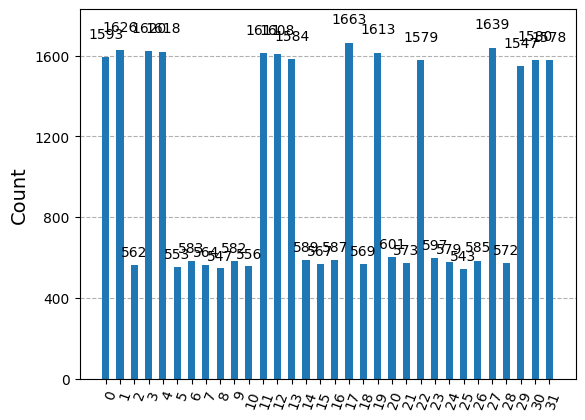

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(Resultado)